this is the final version of the oncoprint, updated on March 3, 2020. the tumour char and reviewed copy number results of the SMGs have been incorporated. run this nb with dl37 env.

In [240]:
import csv
import re
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import style, colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import gridspec
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# constants

hiv+ 73, hiv- 45

In [2]:
# plot parameters
xoffset = 0.125 #colum step, this times the column number gives the x coordinates
yoffset = 0.8 # y coordinate where the legend starts to be plotted
titley = 0.87 # legend title y
legspace = 0.04 # space between legend pathes and the text
rowstep = 0.075 # space between rows of legends

In [295]:
amp_threshold = 2 
del_threshold = -2 

wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/'
patients_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients.txt'
colormap_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'

# colormap and legend cloromap ared identical except the customized text label and order of those text label
legend_cmap = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps_for_legend.txt'
mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency_20190326.txt'
codingmut_rate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/118_patients_strelka_snvs_indels_counts_20190617.txt'
apobec_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/other/master_patient_table_20180813_123samples_all_from_Reanne.txt'
covariate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_covariates_final_20190619.txt'
hrd_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/hrd_scores.txt'
master_table = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_Cervical_Master_Patient_Table_V4_20190703.xlsx'

In [242]:
master = pd.read_excel(master_table, sep='\t', index_col='Patient')
master = master[master.Cohort == 'Discovery']
master.head(2)

,Cohort,HIV status,HAART therapy prior to dx,Stage,Grade,Histology from clinical data,Final histology,Pathology comment,Age,CD4 counts at diagnosis,...,Max APOBEC score,CD8 T-cells,CD4 T-cells,T-cell content,Cibersort p-value,DNA methylation clusters,RNA-Seq clusters,HRD score,MSI score,Tumour content
Patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,Discovery,Positive,YES,Stage IIB,G2,Squamous Cell Carcinoma; Non-Keratinizing,Squamous,NaN,56.0,337.0,...,0.316,0.043,0.229,0.272,0.0,1.0,1.0,6.0,1.2,55.0
HTMCP-03-06-02002,Discovery,Negative,NaN,Stage IB1,G3,Squamous Cell Carcinoma; Non-Keratinizing,Squamous,NaN,62.0,NaN,...,0.260,0.217,0.322,0.648,0.2,1.0,2.0,10.0,1.0,70.0


#### to minize the changes of code, i just check to make sure covariates information in my orignal files are consistent with what is in the latest master table. when in disagreement, update my original files.

# 1. functions

In [243]:
def plot_mutation_rate(ax, df, patients, clrmap_dict):
    ax.set_title("") 
    clrs = [clrmap_dict[m] for m in ['Non-synonymous', 'Synonymous']]
    df_mut_rate = df[['nsyno_mut_rate', 'syno_mut_rate']].reindex(patients)
    df_mut_rate.plot.bar(stacked=True, ax=ax, color=clrs, width=.8)
    ax.set_ylim(0,25)
#     _ = ax.set_xticklabels(df_mut_rate.index.tolist(), fontsize=5)
#     _ = ax.set_yticklabels([int(i) for i in ax.get_yticks()], fontsize=19)
    _ = ax.legend(labels=['Non-synonymous', 'Synonymous'], frameon=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)
    _ = plt.legend('')
    yticklbs = [str(int(i)) for i in ax.get_yticks()]
    yticklbs[0] = ' '
    ax.set_yticklabels(yticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, pad=12, colors='black')
    ax.spines['top'].set_visible(False)
    plt.grid(axis='y', linewidth=0.5, linestyle='-', color='gray')
    ax.set_xticklabels('')
#     ax.margins(x=0.075) # 5% padding in all directions
    return df_mut_rate

In [244]:
def plot_gene_mutation_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    df = df.drop('mfreq', axis=1)
    yticklabels = ['']*len(df.index.tolist())
    yticklabels[0] = ''
    yticklabels[1] = ''
    # bar color consistent to heatmap
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    df = df[['hiv_{}_mfreq'.format(i.lower()[:3]) for i in HIV_status if i.lower()!='unknown']]
    df.plot(kind='barh', ax=ax, stacked=False, width=.8, color=hiv_colors)  
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    # _ = ax.tick_params(axis='y', which='major', labelsize=20, pad=0) # add/reduce space between axis and its ticklables

    _ = ax.set_yticklabels(yticklabels, rotation=0, fontsize=19)
    adjust_spines(ax, ['top', 'right'])

    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
    xticklbs = [str(int(i)) for i in ax.get_xticks()]
    xticklbs[0] = ' '
    xticklbs[4] = ''.join(['% ', xticklbs[4], '  '])
    ax.set_xticklabels(xticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, colors='black')
    ax.spines['top'].set_visible(False)

    plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
    

In [246]:
def plot_cnv_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    yticklabels = df.columns.tolist()
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    print(hiv_colors)
    for c in df.columns[:-1]:
        df[c] = df[c].astype(int)
    ((df.groupby('HIV_status').mean()*100).astype(int)).T.plot(kind='barh', ax=ax, stacked=False, width=0.8, color=hiv_colors)
    
    plt.gca().invert_yaxis()
    adjust_spines(ax, ['top', 'right'])
    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_yticklabels(yticklabels, rotation=0,fontweight='bold',fontsize=20, horizontalalignment='left')
    _ = ax.tick_params(axis='y', which='major', pad=130, labelsize=22)
    #     _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
#     _ = plt.setp(ax.get_yticklines(),visible=False)
    xticklbs = [str(int(i)) for i in ax.get_xticks()]
    print(xticklbs)
    xticklbs[0] = ' '
    xticklbs[3] = ''.join(['  ', xticklbs[3], ' %'])
    ax.set_xticklabels(xticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, colors='black')
    ax.spines['top'].set_visible(False)
    
    plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
 

In [247]:
def plot_mutation_heatmap(ax, df, map_dict, cmap):
    df = df.apply(lambda x: x.map(map_dict)).astype(float)
    sns.heatmap(df, 
                ax=ax, 
                cmap=cmap,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) #cbar_ax=ax1,
#     _ = ax.tick_params(axis='y', which='major', labelsize=27)
#     _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    yticklbs = ['  '.join(re.split('\(|%', str(i.get_text()))[:2]) for i in ax.get_yticklabels()]
    _ = ax.set_yticklabels(yticklbs, fontweight='bold',fontsize=20, rotation=0)
    _ = ax.tick_params(axis='y', which='major', pad=12, labelsize=22)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    # _ = ax.set_yticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    # set heatmap background color, nan values will be this color
    _ = ax.set_facecolor('#f2f2f3')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)
    # set ticklabel fontname, need to add the font first, leave it out for now
#     for tick in ax.get_yticklabels():
#         tick.set_fontname("Helvetica")

    return df

In [248]:
def plot_covariate_track(ax, df, patients, map_dict_cov, cmap_cov):
    df = df[patients]
    df_mapped = df.apply(lambda x: x.map(map_dict_cov)).astype(float)
#     print(df_mapped)
    sns.heatmap(df_mapped, 
                ax=ax, 
                cmap=cmap_cov,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) 
    _ = ax.tick_params(axis='y', which='major', labelsize=19)
    yticklbs = [' '.join(i.get_text().upper().split('_')) for i in ax.yaxis.get_majorticklabels()]
    _ = ax.set_yticklabels(yticklbs, fontsize=20, rotation=0)
#     _ = ax.set_yticklabels(yticklbs, fontweight='bold',fontsize=20, rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)

    return df_mapped

In [249]:
def numeric_covariate(ax, df, patients, ax2):
    df = df[patients]
    ax = sns.heatmap(df, ax=ax, cbar=True, xticklabels=False, yticklabels=True, cbar_ax=ax2, cmap="PuBu")
    # cbar controls if cbar is drawn, cbar_ax controls which ax to draw
    _ = ax.tick_params(axis='y', which='major', labelsize=19)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
#     cax = plt.gcf().axes[1]
#     cax.tick_params(labelsize=50)
#     _ = ax.set_ylabel('HRD_score', fontsize=16, rotation=0)

In [250]:
def add_triangle(ax, features, column, clrmap_dict, leg_name):
    k = 0
    # add legend title
    _ = ax.text(legspace+column*xoffset, titley, leg_name, ha='center', va='center', fontsize=19)
    for feature in features:
        mk = '^'
        if feature == 'deletion':
            mk = 'v'
        clr = clrmap_dict[feature]
        _ = ax.text(legspace+column*xoffset, yoffset-k*rowstep+.01, 
                 feature, 
                 ha='left', 
                 va='center', 
                 fontsize=16)
        _ = ax.scatter(0+column*xoffset, yoffset-k*rowstep, c=clr, marker=mk, s=200)
        k+=1

In [251]:
def add_patches(ax, features, column, clrmap_dict, leg_name):
    k = 0
    # add legend title
    _ = ax.text(legspace+column*xoffset, titley, leg_name, ha='center', va='center', fontsize=19)
    for feature in features:
        types = len(features)
        clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*xoffset, yoffset-k*rowstep), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)
        
        _ = ax.text(legspace+column*xoffset, yoffset-k*rowstep+.01, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=16)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')


In [252]:
def sort_patients(dfxx):
    # exhausitive binary sort
    i = 1e18
    arr = []
    for ix, row in dfxx.iterrows():
        arr.append(row * i)
#         print(i)
        i = i/10
    sorted_pats = pd.DataFrame(arr).sum().sort_values(ascending=False).index.tolist()
#     print(pd.DataFrame(arr).sum().sort_values(ascending=False))
    return sorted_pats

In [253]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    if 'top' in spines:
        ax.xaxis.set_ticks_position('top')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [254]:
def plot_copy_number(df, amp_threshold, del_theshold, ax):
    for ix, row in df.iterrows():
        tmp = row.dropna()
        markers = ['o' if i>=amp_threshold else 'o' for i in tmp ]
        fcs = ['black' if i>=amp_threshold else 'white' for i in tmp ]
        ecs = ['white' if i>=amp_threshold else 'black' for i in tmp ]
        for j, x in enumerate(tmp):
            _ = ax.scatter(tmp.index.tolist()[j]+.35, int(ix)+.5, 
                           marker=markers[j],facecolor=fcs[j], 
                           edgecolor=ecs[j], linewidth=2, s=100)

In [255]:
def plot_cnv_rate_group(ax, df, HIV_status, clrmap_dict):
    ax.set_title("")  
    yticklabels = df.columns.tolist()
    hiv_colors = [clrmap_dict[m] for m in HIV_status]
    print(hiv_colors)
    for c in df.columns[:-1]:
        df[c] = df[c].astype(int)
    ((df.groupby('HIV_status').mean()*100).astype(int)).T.plot(kind='barh', ax=ax, stacked=False, width=0.99, color=hiv_colors)
    
    plt.gca().invert_yaxis()
    adjust_spines(ax, ['top', 'right'])
    ax.legend_.remove()
    _ = ax.yaxis.tick_left()
    ax.spines['right'].set_visible(False) # turn off the axis line
    _ = ax.set_yticks([i-0.2 for i in range(12)])
    _ = ax.set_yticklabels(yticklabels, rotation=0,fontweight='bold',fontsize=20, horizontalalignment='left')
    _ = ax.tick_params(axis='y', which='major', pad=130, labelsize=22)
    #     _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
#     _ = plt.setp(ax.get_yticklines(),visible=False)
    xticklbs = [str(int(i)) for i in ax.get_xticks()]
    print(xticklbs)
    xticklbs[0] = ' '
    xticklbs[3] = ''.join(['  ', xticklbs[3], ' %'])
    ax.set_xticklabels(xticklbs, fontsize=22, rotation=0)
    ax.tick_params(direction='out', length=8, width=1.5, colors='black')
    ax.spines['top'].set_visible(False)
    
    plt.grid(axis='x', linewidth=0.5, linestyle='-', color='gray')
 

In [256]:
def make_cmap_for_heatmap(categories, color_dict):
    '''map category types to a number and make a cmap for heatmap'''
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[m] for m in categories]
    cmap = colors.ListedColormap(clrs)
#     print('colors used:')
#     for cat, c in zip(categories, clrs):
#         print(cat, c)
#     sns.palplot(clrs)
    return (map_dict, cmap)

In [257]:
from matplotlib.patches import Circle
def legend_lines(clr, lb):
    return Line2D([0], [0], color=clr, lw=2, label=lb)

def make_patch(fc, ec, lb):
    return Patch(facecolor=fc, edgecolor=ec, label=lb, linewidth=2)

def remove_axes(ax):
    _ = plt.setp(ax.get_yticklines(), visible=False)
    _ = plt.setp(ax.get_xticklines(), visible=False)
    _ = ax.set_xticklabels('')

def add_legend(ax, legend_handles, title):
    _ = remove_axes(ax)
    _ = ax.set_yticklabels('')
    leg = ax.legend(handles=legend_handles, loc='upper left', fontsize=20,  
                    bbox_to_anchor=(0.02, 0.95), title=title, frameon=False,
                    handlelength=1, handleheight=1.125)
    leg.get_title().set_fontsize(18)
    leg.set_title(leg.get_title().get_text(), prop = {'size':18, 'weight':'bold'})
    leg._legend_box.align = "center"

# 1. patients in cohort

In [258]:
with open(patients_f) as file:
    patients = [line.strip() for line in file]
assert len(patients) == 118
patients[:2]

['HTMCP-03-06-02001', 'HTMCP-03-06-02002']

# 2. color scheme

In [259]:
df_clrs = pd.read_csv(legend_cmap, sep='\t', header=None)
leg_colors = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
hpvs = list(leg_colors.keys())[-18:]

,0,1
0,Negative,#000000
1,Positive,#F15B27


('Negative', '#000000')

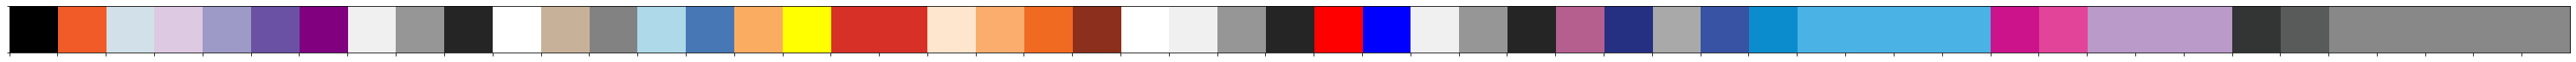

In [260]:
df_clrs = pd.read_csv(colormap_f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]
sns.palplot(df_clrs[1][:])
# df_clrs[0][-18:]

In [261]:
def palplot(pal, size=1):
    """Plot the values in a color palette as a horizontal array.

    Parameters
    ----------
    pal : sequence of matplotlib colors
        colors, i.e. as returned by seaborn.color_palette()
    size :
        scaling factor for size of plot

    """
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    return ax

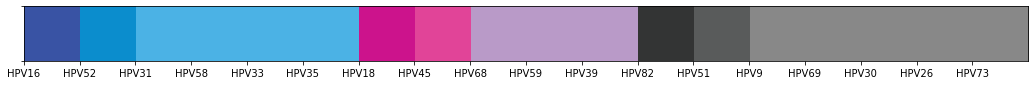

In [262]:
ax = palplot(df_clrs[1][-18:], size=1)
_ = ax.set_xticklabels(df_clrs[0][-18:])

# 3. mutation matrix

In [317]:
mutation_f

'/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency_20190326.txt'

In [318]:
df = pd.read_csv(mutation_f, index_col='percentage')
# sort gene based on frequency
df = df.sort_values('mfreq', ascending=False)
df.head(3)

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
percentage,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Positive,Positive,Unknown,Positive,Positive,Positive,Positive,Positive,Positive
Putative_histology,100,100,102,Adenocarcinoma,Adenocarcinoma,Adenosquamous,Adenosquamous,Adenosquamous,Adenosquamous,Neuroendocrine,...,Squamous,Squamous,Squamous,Adenosquamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adenosquamous
PIK3CA(35%),28,44,35,Non-synonymous,NaN,NaN,NaN,Non-synonymous,NaN,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [319]:
df

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
percentage,,,,,,,,,,,,,,,,,,,,,
HIV_status,100,100,102,Negative,Negative,Negative,Negative,Negative,Negative,Negative,...,Positive,Positive,Positive,Unknown,Positive,Positive,Positive,Positive,Positive,Positive
Putative_histology,100,100,102,Adenocarcinoma,Adenocarcinoma,Adenosquamous,Adenosquamous,Adenosquamous,Adenosquamous,Neuroendocrine,...,Squamous,Squamous,Squamous,Adenosquamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adenosquamous
PIK3CA(35%),28,44,35,Non-synonymous,NaN,NaN,NaN,Non-synonymous,NaN,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1(19%),16,22,19,NaN,Synonymous,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2(14%),9,22,14,NaN,NaN,Frameshift,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FBXW7(10%),8,13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CASP8(7%),6,6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SLC35G5(7%),9,2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PCDHGA12(6%),5,7,6,NaN,NaN,NaN,NaN,NaN,Synonymous,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
# sort patients based on if a gene is mutated or not in the order of genes
dfx = df[[i for i in tqdm(df.columns) if i.startswith('HTMCP')]]
dfy = dfx.drop(['HIV_status','Putative_histology' ])
dfq = dfx.loc[['HIV_status','Putative_histology'],]
dfz = dfy.notnull()
dfz.head(2)

100%|██████████| 121/121 [00:00<00:00, 225260.00it/s]


,HTMCP-03-06-02075,HTMCP-03-06-02150,HTMCP-03-06-02182,HTMCP-03-06-02326,HTMCP-03-06-02203,HTMCP-03-06-02176,HTMCP-03-06-02047,HTMCP-03-06-02214,HTMCP-03-06-02063,HTMCP-03-06-02042,...,HTMCP-03-06-02225,HTMCP-03-06-02259,HTMCP-03-06-02330,HTMCP-03-06-02377,HTMCP-03-06-02393,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02434,HTMCP-03-06-02437,HTMCP-03-06-02442
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(35%),True,False,False,False,True,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
FAT1(19%),False,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [321]:
dfxx = pd.concat([dfz, dfq]).drop('Putative_histology').replace('Positive', True).replace('Negative', False).replace('Unknown', False)
sorted_pats = sort_patients(dfxx)
sorted_patients = ['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq',] + sorted_pats
df = df[sorted_patients]
# remove rows of histology and hiv status
df = df.drop(['HIV_status', 'Putative_histology'])
df.head(2)

,hiv_pos_mfreq,hiv_neg_mfreq,mfreq,HTMCP-03-06-02260,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02428,HTMCP-03-06-02215,HTMCP-03-06-02036,HTMCP-03-06-02040,...,HTMCP-03-06-02377,HTMCP-03-06-02332,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02185,HTMCP-03-06-02156,HTMCP-03-06-02037,HTMCP-03-06-02008,HTMCP-03-06-02046
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(35%),28,44,35,Non-synonymous,Multi_hit,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1(19%),16,22,19,Non-synonymous,Multi_hit,Non-synonymous,Multi_hit,Non-synonymous,Stop gained,Synonymous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [322]:
# get ordered smgs and patient
smgs = df.index.tolist()
smgs = [i.split('(')[0] for i in smgs]
smgs[:2]
patients = df.columns.tolist()[3:]
patients[:2]

['PIK3CA', 'FAT1']

['HTMCP-03-06-02260', 'HTMCP-03-06-02214']

# 5. covariates

In [278]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/covariates_20200303.csv'
# df_cov.to_csv(of)
df_cov = pd.read_csv(of, index_col='covariates')
df_cov

,HTMCP-03-06-02260,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02428,HTMCP-03-06-02215,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,...,HTMCP-03-06-02377,HTMCP-03-06-02332,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02185,HTMCP-03-06-02156,HTMCP-03-06-02037,HTMCP-03-06-02008,HTMCP-03-06-02046
covariates,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Negative,Negative,Positive,Negative,Negative,Negative,Positive,Negative,Negative,...,unknown,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Histology,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Adenocarcinoma,Squamous,Squamous,...,Adenosquamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
APOBEC_signature,>0.4,>0.4,<0.2,>0.4,0.2-0.4,<0.2,0.2-0.4,<0.2,0.2-0.4,>0.4,...,<0.2,0.2-0.4,<0.2,<0.2,<0.2,<0.2,0.2-0.4,<0.2,<0.2,<0.2
Clinical_stage,Stage I,Stage II,Stage III,Stage II,Stage II,Stage I,Stage II,Stage IV,Stage I,Stage II,...,Stage III,Stage IV,unknown,Stage II,Stage II,Stage II,Stage II,Stage III,Stage III,Stage II
Age_at_diagnosis,<45,45-65,45-65,45-65,45-65,45-65,45-65,<45,45-65,45-65,...,45-65,45-65,unknown,45-65,45-65,<45,>65,>65,45-65,<45
HRD,10-30,10-30,10-30,10-30,<=10,10-30,10-30,10-30,<=10,10-30,...,10-30,<=10,>30,10-30,10-30,10-30,10-30,10-30,<=10,10-30
HPV clade,A7,A9,A7,A9,A9,A9,A9,A7,A9,A9,...,A7,A9,Other,A9,A9,A7,A9,A9,Other,A9
HPV type,HPV18,HPV16,HPV18,HPV16,HPV16,HPV16,HPV52,HPV18,HPV52,HPV16,...,HPV45,HPV16,HPV82,HPV31,HPV16,HPV18,HPV33,HPV52,HPV9,HPV16


# 6. coding mutation rate per mb

In [279]:
df_cmutrate = pd.read_csv(codingmut_rate_f, sep='\t', index_col='patient')

df_cmutrate = df_cmutrate.loc[patients,]
df_cmutrate.head(2)
df_cmutrate.shape

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,syno_mut_rate,nsyno_mut_rate,coding_mut_rate
patient,,,,,,,,,,,,,
HTMCP-03-06-02260,89497,720,1376,11,518,1,90217,1387,519,868,4.457057,7.454192,11.911250
HTMCP-03-06-02214,104274,848,1722,6,710,1,105122,1728,711,1017,6.105911,8.733772,14.839683


(118, 13)

# 7. copy number changes reported  by GATK CNVs

In [49]:
# initially based copy number on gistic thresholded all_gene_thresholded results, present high level copy gain or loss
# here we chose to use tumour char copy number results, all reviewed. to make plotting easier and consistent, 
# I manually modifed the input file by denote amplification as 2, and homozygous deletion as -2

this is an important paper to reference when decide the thresholds for copy number amplification and deletion in the SMGs

https://www.pnas.org/content/suppl/2007/11/20/0710052104.DC1#F7

### cnv heatmap based on gistic all_gene_threshold file

reference paper: https://www.sciencedirect.com/science/article/pii/S1535610819300960#fig1

definition of gain, amplification, loss, and deletion:

(C) Known cancer-related genes located in significant GISTIC peaks with residual q < 1 × 10−4 (amplification, gain, neutral, loss, and deletion were defined as GISTIC +2, +1, 0, −1, and −2, respectively).

(A–C) Asterisks indicate associations with mRNA subtypes (intrinsic subtype, ASCAT ploidy, lymph node status, and somatic copy-number alterations were tested using Pearson's chi-square test; ASCAT purity and homologous recombination deficiency [HRD] score were tested using the Kruskal-Wallis test; age at surgery was tested using analysis of variance; apocrine differentiation and somatic mutations were tested using Fisher's exact test. ∗∗p < 0.01, ∗p < 0.05).

To assess somatic copy number alterations (CNAs), reported oncogenes and tumor suppressor genes observed in the top rank (residual q < 1 × 10−4) GISTIC peaks were examined 

 GISTIC2.0 was run with the following parameters changed from the default settings (-ta 0.2 -td 0.2 -genegistic 1 -smallmem 1 -broad 1 -conf 0.95 -rx 0 –brlen 0.7 -cap 3.5 –armpeel 1).
 
#### all_thresholded.by_genes.txt
The table in this file is obtained by applying both low- and high-level thresholds to the gene copy levels of all the samples. The entries with value +/- 2 exceed the high-level thresholds for amps/dels, and those with +/- 1 exceed the low-level thresholds but not the high-level thresholds. The low-level thresholds are just the 'amplifications_threshold' and 'deletions_threshold' noise threshold input values (typically 0.1 or 0.3) and are the same for every threshold.
By contrast, the high-level amplification (or deletion) thresholds are calculated on a sample-by-sample basis and are based on the maximum (or minimum) median arm-level amplification (or deletion) copy number found in the sample. The idea, for deletions anyway, is that this level is a good approximation for hemizygous given the purity and ploidy of the sample. The actual cutoffs used for each sample can be found in a table in the sample_cutoffs.txt file.


* not sure if I can say below  
I think this means that GISTIC does take purity and ploidy into account by looking at arm-level amplification and deletion level in each sample and use that as thresholding value to 
 
 

In [280]:
tumour_char_cnv = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/tumour_char_gistic_copy_number_comparison_20200212.xls'
cnvs = pd.read_excel(tumour_char_cnv, sheet_name='final_results_encoded_for_oncoprint_20200302', index_col='Gene Symbol')
cnvs.columns = [''.join(['HTMCP-03-06-0', str(i)]) for i in cnvs.columns]

cnvs.head()

,HTMCP-03-06-02260,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02428,HTMCP-03-06-02215,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,...,HTMCP-03-06-02377,HTMCP-03-06-02332,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02185,HTMCP-03-06-02156,HTMCP-03-06-02037,HTMCP-03-06-02008,HTMCP-03-06-02046
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
PIK3CA,1,1,1,1,1,2,1,2,2,1,...,0,1,1,1,1,1,0,2,0,1
FAT1,0,1,-1,0,-1,-1,1,-1,0,0,...,-1,0,1,0,0,-1,-1,0,0,0
MLL2,0,0,0,1,0,-1,1,0,0,-1,...,0,-1,1,-1,-1,-1,0,0,0,0
FBXW7,0,1,-1,0,0,-1,1,-1,0,0,...,0,0,1,0,0,-1,-1,0,0,0
CASP8,1,1,-1,0,0,-1,0,0,0,0,...,0,0,-1,-1,1,0,0,0,0,-1


In [281]:
cnvs.isin([2,-2]).any(axis=1)

Gene Symbol
PIK3CA       True
FAT1         True
MLL2         True
FBXW7       False
CASP8       False
SLC35G5     False
PCDHGA12     True
MAPK1        True
PSPC1       False
ZNF750      False
PCDHA9       True
ZC3H6       False
dtype: bool

In [282]:
cnvs_thresholded = cnvs[(cnvs==amp_threshold)|(cnvs==del_threshold)]
cnvs_thresholded = cnvs_thresholded.reset_index(drop=True)

# enforce patient order
assert (cnvs_thresholded.columns == patients).all()

cnvs_thresholded.columns = [i for i in range(cnvs_thresholded.shape[1])]
cnvs_thresholded.head(2)

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [283]:
# for the right hbar plot cnv counts in hiv+ and - patient
dfcnvtmp = (cnvs >=2)|(cnvs <=-2)

dfcnvtmp2 = pd.concat([dfcnvtmp, df_cov.loc[['HIV_status'],:]], sort=False).T 
dfcnvtmp2.head(2)

,PIK3CA,FAT1,MLL2,FBXW7,CASP8,SLC35G5,PCDHGA12,MAPK1,PSPC1,ZNF750,PCDHA9,ZC3H6,HIV_status
HTMCP-03-06-02260,False,False,False,False,False,False,False,False,False,False,False,False,Positive
HTMCP-03-06-02214,False,False,False,False,False,False,False,False,False,False,False,False,Negative


In [284]:
df_cov.loc['HPV type', :].unique()

array(['HPV18', 'HPV16', 'HPV52', 'HPV68', 'HPV73', 'HPV31', 'HPV45',
       'HPV58', 'HPV33', 'HPV59', 'HPV30', 'HPV82', 'HPV51', 'HPV26',
       'HPV35', 'HPV69', 'HPV9'], dtype=object)

In [285]:
leg_colors['HPV16']

'#3953A4'

In [286]:
all_patches = [make_patch(v, 'white', k) for k, v in leg_colors.items()]
# all_lines = [legend_lines(v, k) for k, v in clr_dict.items()]
c1 = Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor="black", markeredgecolor='black', label='amplification')
c2 = Line2D(range(1), range(1), color="white", marker='o',markersize=10, markerfacecolor="white", markeredgecolor='black', label='deletion')
cnv_circles = [c1, c2]
white_patch = make_patch('white', 'gray', 'unknown' )
hiv_patches = all_patches[:2] + [white_patch]
histology_patches = all_patches[3:8]
age_patches = all_patches[8:11] +  [white_patch]
mut_patches = all_patches[11:16] + [all_patches[18]]
stage_patches = all_patches[19:23] + [white_patch]
apobec_patches = all_patches[23:26]
cn_circles = cnv_circles
hrd_patches = all_patches[28:31]
clade_patches = all_patches[31:34]
# hpvtype_patches = all_patches[34:51]
hpvtype_patches = all_patches[34:37] + all_patches[40:43] + all_patches[45:48]
# lines = all_lines[11:]
leg_patches = [hiv_patches, histology_patches, age_patches, mut_patches,
              stage_patches, apobec_patches, hrd_patches, cn_circles, clade_patches, hpvtype_patches]

['#000000', '#F15B27', '#FFFFFF']
['0', '5', '10', '15', '20']


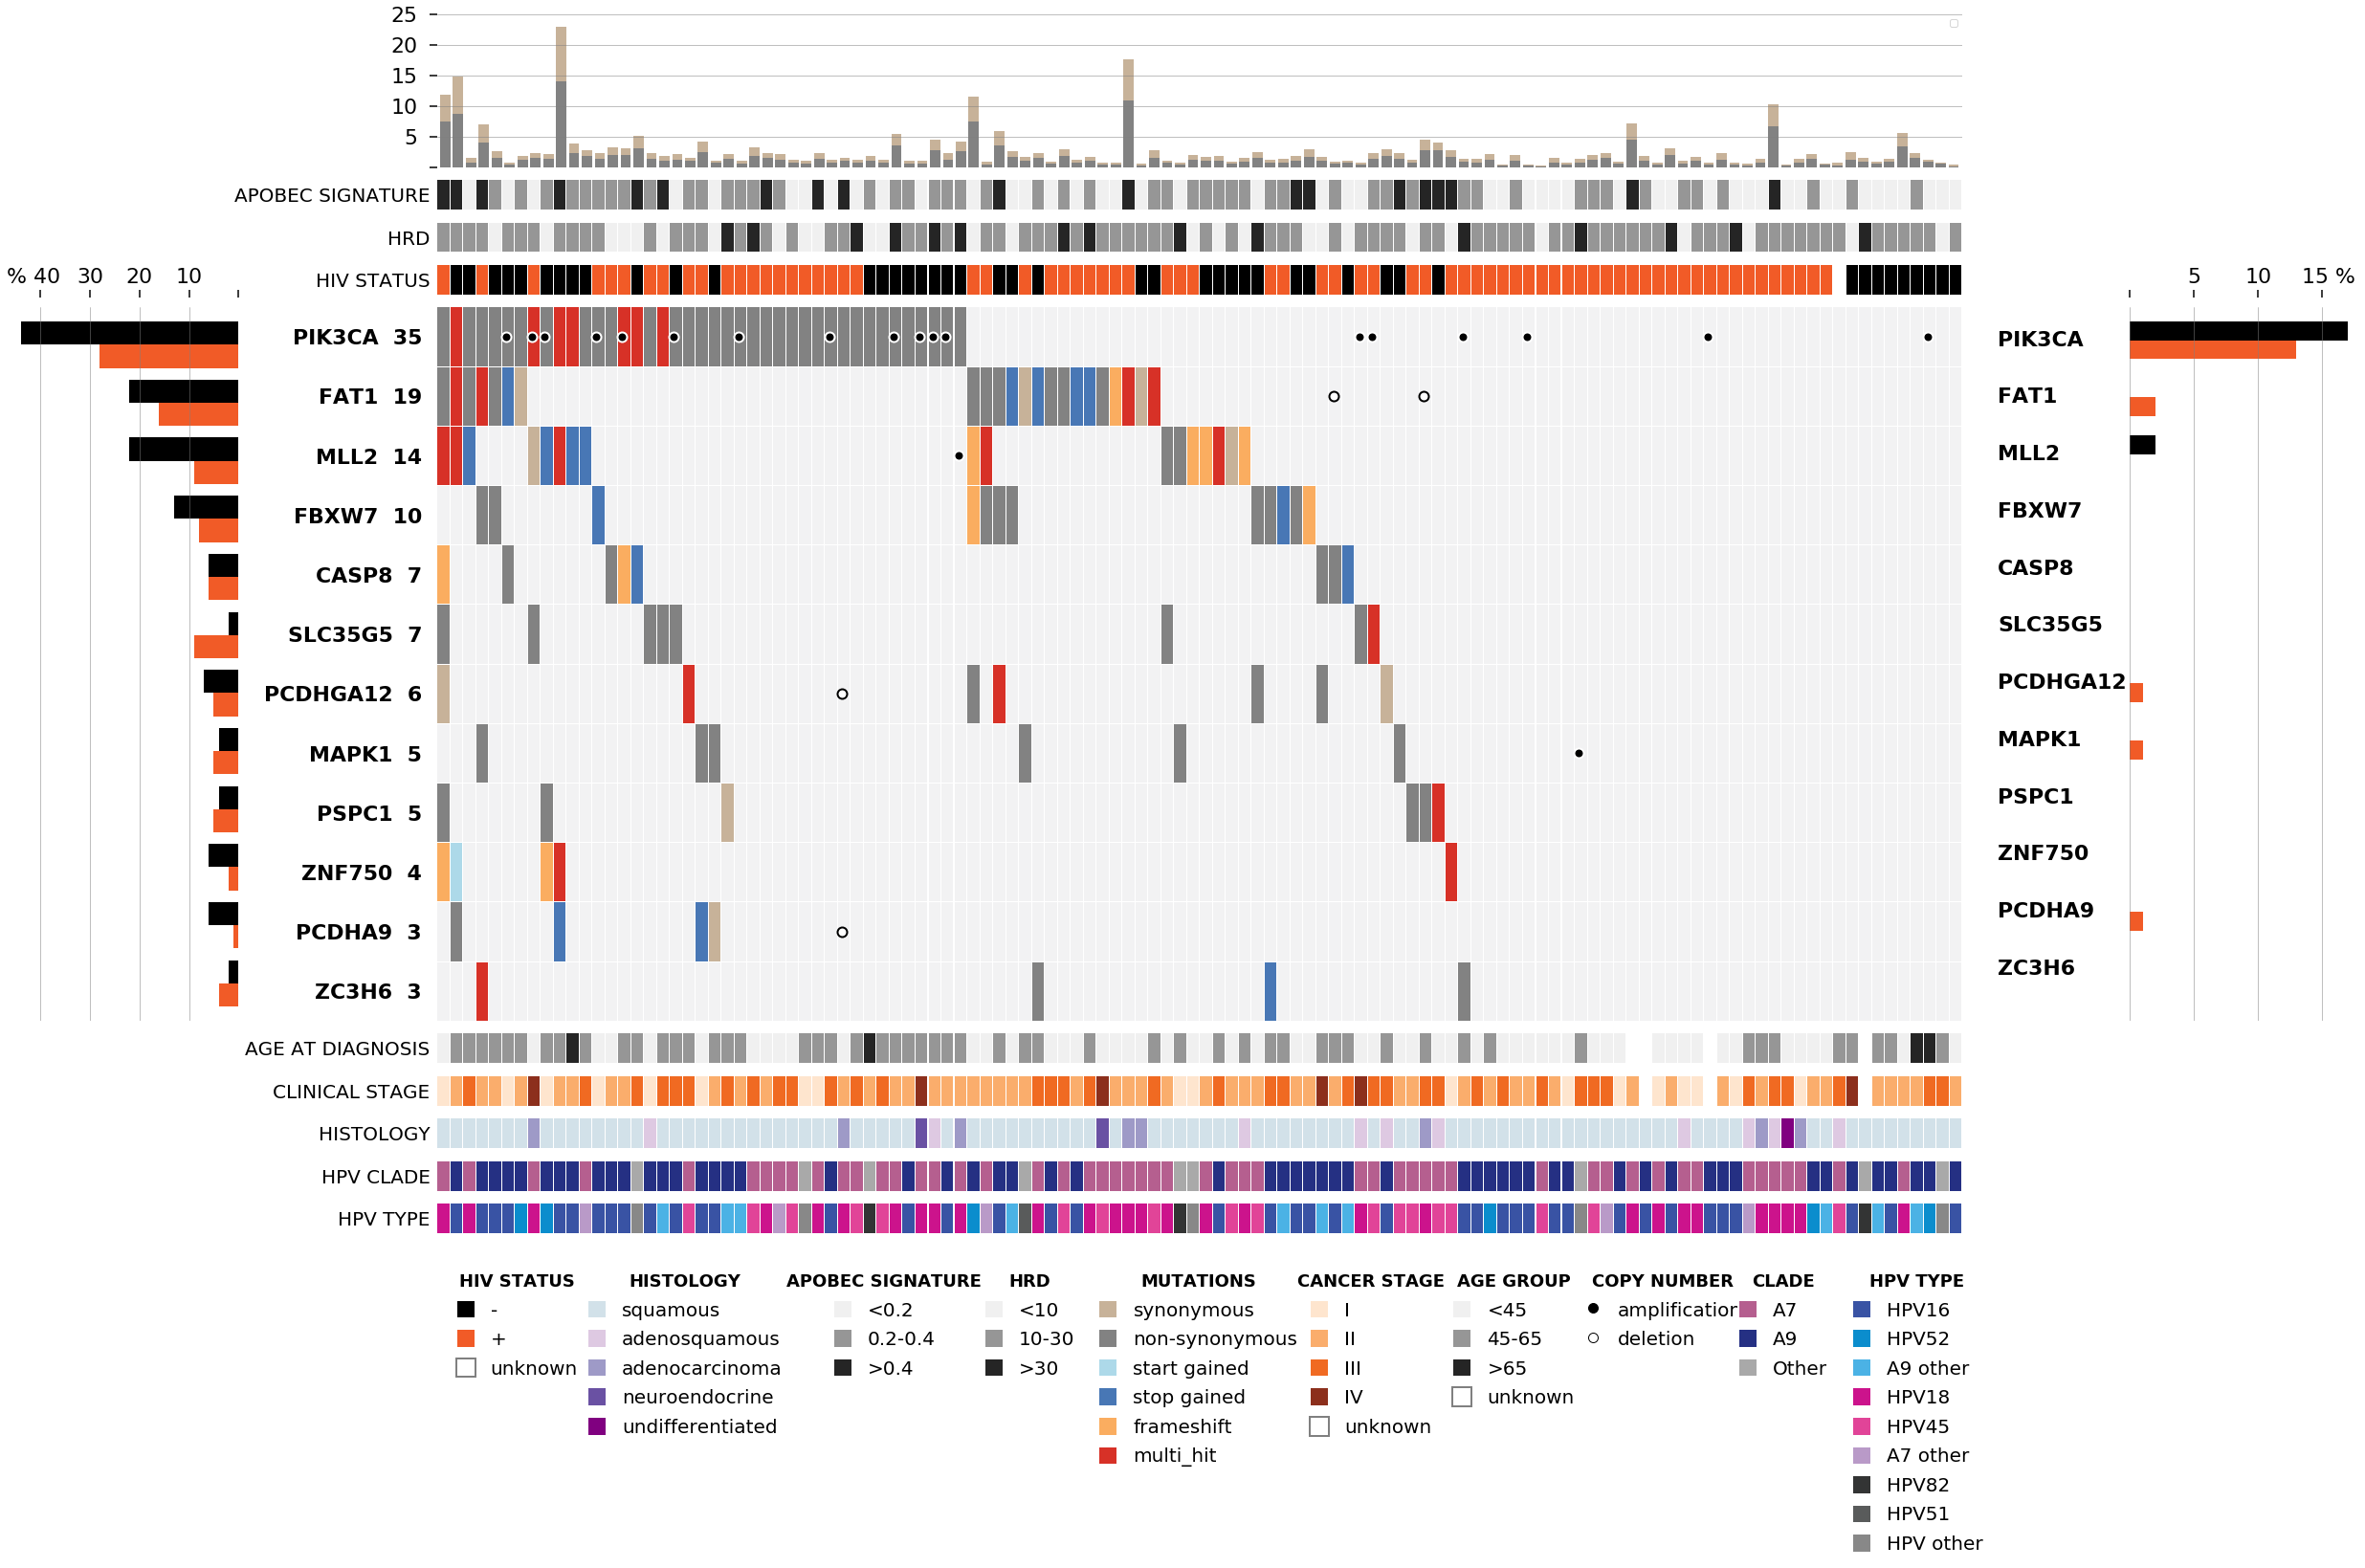

In [323]:

# df: mutation matrix
# patients: ordered columns
    
nrows = df.shape[0]    
fig = plt.figure(figsize=(44,1.15*nrows*2), facecolor='white')


gs = gridspec.GridSpec(11,5,                            
                       width_ratios=[3,2.6,20,2.2,3], 
                       height_ratios=[3,0.6,0.6,0.6,14,0.6,0.6,0.6, 0.6, 0.6, 4],
                       wspace=0, # horizontal space
                       hspace=0.1  # vertical space
                      )
# make sure patients has the right order

patients = [p for p in df.columns.tolist() if p.startswith('HTMCP')]
# dfa plot the heatmap of different types of mutations
histology = ['Adenocarcinoma', 'Squamous', 'Neuroendocrine', 'Adenosquamous', 'Undifferentiated']
HIV_status = ['Negative', 'Positive', 'unknown']
mutations = ['Non-synonymous', 
#              'Codon indel', 
             'Frameshift',              
#              'Splice site', 
             'Stop gained',
             'Start gained',
             'Synonymous',
             'Multi_hit']
# tumor_grades = ['G1', 'G2', 'G3','unknown']
stages = ['Stage I',  'Stage II', 'Stage III', 'Stage IV', 'unknown']
ages = ['<45', '45-65', '>65', 'unknown']
hrds = ['<=10', '10-30', '>30']
apobec = ['<0.2', '0.2-0.4', '>0.4']
clade = ['A7', 'A9', 'Other']
copy_numbers = ['amplification', 'deletion']
hpvtypes =['HPV18', 'HPV16', 'HPV52', 'HPV68', 'HPV73', 'HPV31', 'HPV45',
       'HPV58', 'HPV33', 'HPV59', 'HPV30', 'HPV82', 'HPV51', 'HPV26',
       'HPV35', 'HPV69', 'HPV9']

b_lst = ['mfreq', 'hiv_pos_mfreq', 'hiv_neg_mfreq']
d_lst = ['tumor_grade']
e_lst = ['age_at_diagnosis']
g_lst = ['clinical_stage']
dfa = df.drop(b_lst, axis=1)

# dfb for unstacked barplot of mutation rate in hiv+ and - and full cohort
dfb = df[b_lst].astype(float)

# # plot coding mutation per mb mutation rate 
gs2 = gs[2]
ax2 = plt.subplot(gs2, facecolor='white', frameon=False)
df_mutrate = plot_mutation_rate(ax2, df_cmutrate, patients, color_dict)

# this is not necessary, reorder patients happens in plot_covariate_track function, but do it anyway
df_cov = df_cov[patients]

# add in molecular covariate track
map_dict_cov, cmap_cov = make_cmap_for_heatmap(apobec, color_dict)
df_apobec = df_cov.loc[['APOBEC_signature'],:]
ax7 = plt.subplot(gs[7], facecolor='white')
df_apobecrt = plot_covariate_track(ax7, df_apobec, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(hrds, color_dict)
df_hrd = df_cov.loc[['HRD'],:]
ax12 = plt.subplot(gs[12], facecolor='white')
df_hrdrt = plot_covariate_track(ax12, df_hrd, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(HIV_status, color_dict)
df_hiv = df_cov.loc[['HIV_status'],:]
# print(df_hiv)
ax17 = plt.subplot(gs[17], facecolor='white')
df_hivrt = plot_covariate_track(ax17, df_hiv, patients, map_dict_cov, cmap_cov)

# plot cn alteration percentage per gene
ax24 = plt.subplot(gs[24], facecolor='white', frameon=True)
plot_cnv_rate_group(ax24, dfcnvtmp2, HIV_status, color_dict)

# plot mutation rate in hiv+ and - group, grouped barplot
ax20 = plt.subplot(gs[20], facecolor='white')
plot_gene_mutation_rate_group(ax20, dfb, HIV_status, color_dict)

# plot heatmap for gene mutations
# make map dictionary to map types to a number so that heatmap can plot
map_dict, cmap = make_cmap_for_heatmap(mutations, color_dict)
ax22 = plt.subplot(gs[22], facecolor='beige')
df_mutheatmap = plot_mutation_heatmap(ax22, dfa, map_dict, cmap)

# add in copy number changes to mutation heatmap
cnvs_thresholded1 = cnvs[(cnvs==amp_threshold)|(cnvs==del_threshold)]
cnvs_thresholded = cnvs_thresholded1.reset_index(drop=True)
cnvs_thresholded.columns = [i for i in range(cnvs_thresholded.shape[1])]
# tumour char, should not remove the first two rows
cnvs_thresholded = cnvs_thresholded.iloc[0:, :].reset_index(drop=True)
plot_copy_number(cnvs_thresholded, amp_threshold, del_threshold, ax22)


# # add in clinical covariate track
map_dict_cov, cmap_cov = make_cmap_for_heatmap(ages, color_dict)
df_age = df_cov.loc[['Age_at_diagnosis'],:]
ax27 = plt.subplot(gs[27], facecolor='white')
df_agert = plot_covariate_track(ax27, df_age, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(stages, color_dict)
df_stage = df_cov.loc[['Clinical_stage'],:]
ax32 = plt.subplot(gs[32], facecolor='white')
df_stagert = plot_covariate_track(ax32, df_stage, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(histology, color_dict)
df_histo = df_cov.loc[['Histology'],:]
ax37 = plt.subplot(gs[37], facecolor='white')
df_histort = plot_covariate_track(ax37, df_histo, patients, map_dict_cov, cmap_cov)


map_dict_cov, cmap_cov = make_cmap_for_heatmap(clade, color_dict)
df_clade = df_cov.loc[['HPV clade'],:]
ax42 = plt.subplot(gs[42], facecolor='white')
df_cladert = plot_covariate_track(ax42, df_clade, patients, map_dict_cov, cmap_cov)

# add in hpv types
map_dict_cov, cmap_cov = make_cmap_for_heatmap(hpvtypes, color_dict)
df_clade = df_cov.loc[['HPV type'],:]
ax47 = plt.subplot(gs[47], facecolor='white')
df_cladert = plot_covariate_track(ax47, df_clade, patients, map_dict_cov, cmap_cov)

# plot all legend
gs52 = gs[52]
ax52 =  plt.subplot(gs52, frameon=False)
# add subplots in an ax made by plt.subplots to accommodate legend panels
axxs = gridspec.GridSpecFromSubplotSpec(1,10 , subplot_spec=ax52, 
                                        width_ratios=[1.2,2,2,1,2,1.5,1.2,1.5,1, 1.5], hspace=1)
leg_titles = ['HIV STATUS', 'HISTOLOGY', 'APOBEC SIGNATURE', 'HRD',
             'MUTATIONS', 'CANCER STAGE', 'AGE GROUP', 'COPY NUMBER', 'CLADE', 'HPV TYPE']
leg_patches = [hiv_patches, histology_patches, apobec_patches, hrd_patches,
               mut_patches, stage_patches, age_patches, cn_circles, clade_patches, hpvtype_patches]
for i, (ltitle, lpatches) in enumerate(zip(leg_titles, leg_patches)):
    axx = plt.subplot(axxs[i], frame_on=False)
    add_legend(axx, lpatches, ltitle)



# a few checks to make sure patient order is consistent
# coding mutation rate  and mutation heatmap
assert (df_mutrate.index == df_mutheatmap.columns).all()
# mutation heatmap and covariate track
assert (df_mutheatmap.columns == df_apobec.columns).all()
# mutation heatmap and molecular covariate track
assert (df_mutheatmap.columns == df_hrd.columns).all()
# mutation heatmap and copy number overlay
assert (df_mutheatmap.columns == cnvs_thresholded1.columns).all()

# gene order needs to be consistent 
# mutation heatmap and copy number overlay
genes_right = dfcnvtmp2.columns[:-1]
genes_left = [g.split('(')[0] for g in dfb.index]
genes_middle = [g.split('(')[0] for g in dfa.index]
assert (genes_left == genes_right).all()
assert genes_left == genes_middle
assert (patients == df_mutheatmap.columns).all()

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/smgs_cnvs_oncoprint_20190325.png'
pdf = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/smgs_cnvs_oncoprint_2020303.pdf'
# %time plt.savefig(of, bbox_inches='tight',dpi=200)
plt.savefig(pdf,bbox_inches='tight',dpi=350)
plt.show()

In [304]:
7/118
6/118
8/118
17/118

0.059322033898305086

0.05084745762711865

0.06779661016949153

0.1440677966101695

In [306]:
df.columns

Index(['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq', 'HTMCP-03-06-02260',
       'HTMCP-03-06-02214', 'HTMCP-03-06-02074', 'HTMCP-03-06-02428',
       'HTMCP-03-06-02215', 'HTMCP-03-06-02036', 'HTMCP-03-06-02040',
       ...
       'HTMCP-03-06-02377', 'HTMCP-03-06-02332', 'HTMCP-03-06-02222',
       'HTMCP-03-06-02197', 'HTMCP-03-06-02194', 'HTMCP-03-06-02185',
       'HTMCP-03-06-02156', 'HTMCP-03-06-02037', 'HTMCP-03-06-02008',
       'HTMCP-03-06-02046'],
      dtype='object', length=121)

In [313]:
df.drop(['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq'], axis=1)#.isna().sum(axis=1)

,HTMCP-03-06-02260,HTMCP-03-06-02214,HTMCP-03-06-02074,HTMCP-03-06-02428,HTMCP-03-06-02215,HTMCP-03-06-02036,HTMCP-03-06-02040,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,...,HTMCP-03-06-02377,HTMCP-03-06-02332,HTMCP-03-06-02222,HTMCP-03-06-02197,HTMCP-03-06-02194,HTMCP-03-06-02185,HTMCP-03-06-02156,HTMCP-03-06-02037,HTMCP-03-06-02008,HTMCP-03-06-02046
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(35%),Non-synonymous,Multi_hit,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,Non-synonymous,Multi_hit,Non-synonymous,Multi_hit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1(19%),Non-synonymous,Multi_hit,Non-synonymous,Multi_hit,Non-synonymous,Stop gained,Synonymous,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2(15%),Multi_hit,Multi_hit,Stop gained,NaN,NaN,NaN,NaN,Synonymous,Stop gained,Multi_hit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FBXW7(10%),NaN,NaN,NaN,Non-synonymous,Non-synonymous,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CASP8(7%),Frameshift,NaN,NaN,NaN,NaN,Non-synonymous,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SLC35G5(7%),Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,Non-synonymous,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PCDHGA12(6%),Synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAPK1(5%),NaN,NaN,NaN,Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PSPC1(5%),Non-synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non-synonymous,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [316]:
df.drop(['hiv_pos_mfreq', 'hiv_neg_mfreq', 'mfreq'], axis=1).notnull().mean(axis=1)

percentage
PIK3CA(35%)     0.347458
FAT1(19%)       0.186441
MLL2(15%)       0.144068
FBXW7(10%)      0.101695
CASP8(7%)       0.067797
SLC35G5(7%)     0.067797
PCDHGA12(6%)    0.059322
MAPK1(5%)       0.050847
PSPC1(5%)       0.050847
ZNF750(4%)      0.042373
PCDHA9(3%)      0.033898
ZC3H6(3%)       0.033898
dtype: float64